<a href="https://colab.research.google.com/github/bioinfoUQAM/Identification-Tracking-Cows/blob/main/models/notebooks/demo_identity_from_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics torch torchvision opencv-python pillow numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.4/810.4 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 35.6 MB/s eta 0:00:00


In [2]:
import os
import urllib.request
import torch
import cv2
import numpy as np
from PIL import Image
from ultralytics import YOLO
from torchvision import models, transforms
from IPython.display import display


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
NUM_CLASSES = 29
MAX_VIDEO_FRAMES = 120

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cpu


In [4]:
os.makedirs("models", exist_ok=True)

YOLO_URL = "https://github.com/bioinfoUQAM/Identification-Tracking-Cows/releases/download/v1.0-models/best_yolov8_detection.pt"
ID_URL = "https://github.com/bioinfoUQAM/Identification-Tracking-Cows/releases/download/v1.0-models/best_model_efficientnet_b0.ckpt"

yolo_path = "models/best_yolov8_detection.pt"
id_path = "models/best_model_efficientnet_b0.ckpt"

if not os.path.exists(yolo_path):
    urllib.request.urlretrieve(YOLO_URL, yolo_path)

if not os.path.exists(id_path):
    urllib.request.urlretrieve(ID_URL, id_path)

print("Models ready.")


Models ready.


In [5]:
yolo = YOLO(yolo_path)

model = models.efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(
    model.classifier[1].in_features,
    NUM_CLASSES
)

ckpt = torch.load(id_path, map_location=device)
state_dict = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
state_dict = {k.replace("model.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict, strict=False)
model.eval().to(device)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [7]:
from google.colab import files
uploaded = files.upload()
video_path = list(uploaded.keys())[0]


Saving Captura de Tela 2026-02-16 às 7.13.23 PM.png to Captura de Tela 2026-02-16 às 7.13.23 PM.png



0: 640x608 6 cows, 684.3ms
Speed: 2.3ms preprocess, 684.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


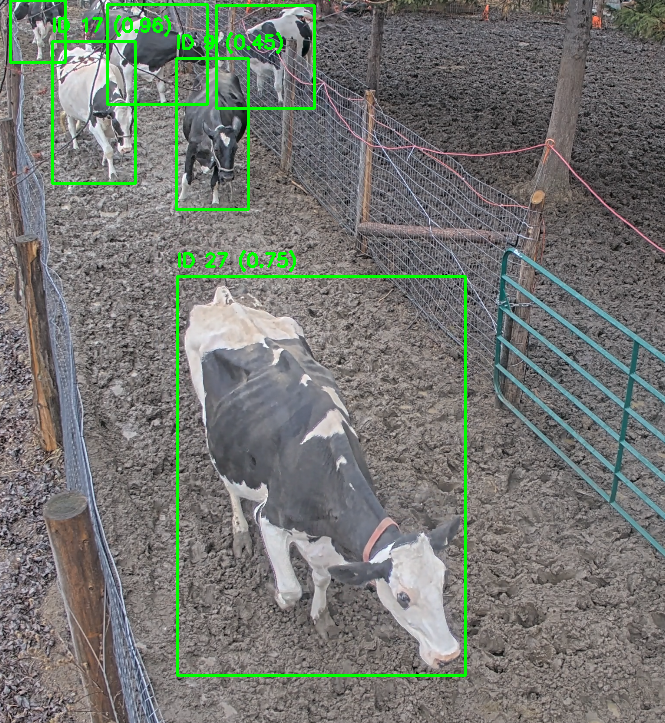

In [8]:
cap = cv2.VideoCapture(video_path)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_count >= MAX_VIDEO_FRAMES:
        break

    results = yolo(frame)

    for r in results:
        for box in r.boxes:
            if r.names[int(box.cls)] != "cow":
                continue

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            crop = frame[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            crop_pil = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            inp = preprocess(crop_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                probs = torch.softmax(model(inp), dim=1)[0]
                pid = probs.argmax().item()
                conf = probs.max().item()

            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(
                frame,
                f"ID {pid} ({conf:.2f})",
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 255, 0),
                2
            )

    frame_count += 1
    display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

cap.release()
